# Titanic - Machine Learning from Disaster

All data fields should be converted to their smallest possible representation (float to int, int to bool etc).

In [1]:
# Data processing
import numpy as np
import pandas as pd

# # Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Statistics
from scipy.stats import skew

## Raw Data - Training

Bring in the raw data and inspect it.

In [2]:
train_df = pd.read_csv('raw_data/train.csv')
display(train_df.head())
train_df.shape

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 12)

The training dataset includes predictors and a target variable.

It is clear that some data processing is needed to make the data easier to understand.

### Target Selection

Select the target variable. In this instance it is the 'Survived' column.

In [3]:
x_train_df = train_df.drop('Survived', axis=1)
y_train_sr = train_df['Survived']

## Raw Data - Testing

In [4]:
# This contains the predictors only.
x_test_df = pd.read_csv('raw_data/test.csv')
display(x_test_df.head())
x_test_df.shape

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


(418, 11)

The testing dataset only includes the predictors.

## Initial Data Preprocessing

Initial cleaning of the dataset so that it is easier to understand and interpret later on.

Base this on viewing the dataframe earlier.

In [5]:
def initial_preprocessing(df):

    # Drop redundant columns
    df.drop('PassengerId', axis=1, inplace=True)

    # Change the column names according to the data dictionary
    new_col_names = {'Pclass': 'Ticket Class', 'SibSp': 'Num Siblings/Spouses Onboard', 'Parch': 'Num Parents/Children Onboard',
                    'Ticket': 'Ticket Num', 'Cabin': 'Cabin Num', 'Embarked': 'Embarkment Port'}
    df.rename(columns=new_col_names, inplace=True)

    # Change the column order so it is easier to follow
    new_col_order = ['Name', 'Sex', 'Age', 'Num Siblings/Spouses Onboard', 'Num Parents/Children Onboard',
                    'Ticket Num', 'Ticket Class', 'Fare', 'Cabin Num', 'Embarkment Port']
    df = df[new_col_order]

    return df

In [6]:
x_train_df = initial_preprocessing(x_train_df)
display(x_train_df.head())

,Name,Sex,Age,Num Siblings/Spouses Onboard,Num Parents/Children Onboard,Ticket Num,Ticket Class,Fare,Cabin Num,Embarkment Port
0,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,3,7.2500,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,1,71.2833,C85,C
2,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,3,7.9250,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,1,53.1000,C123,S
4,"Allen, Mr. William Henry",male,35.0,0,0,373450,3,8.0500,NaN,S


In [7]:
x_test_df = initial_preprocessing(x_test_df)
display(x_test_df.head())

,Name,Sex,Age,Num Siblings/Spouses Onboard,Num Parents/Children Onboard,Ticket Num,Ticket Class,Fare,Cabin Num,Embarkment Port
0,"Kelly, Mr. James",male,34.5,0,0,330911,3,7.8292,NaN,Q
1,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,3,7.0000,NaN,S
2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,2,9.6875,NaN,Q
3,"Wirz, Mr. Albert",male,27.0,0,0,315154,3,8.6625,NaN,S
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,3,12.2875,NaN,S


## Initial Exploratory Data Analysis (EDA)

Only perform this on our training dataset so that we don't incur any bias.

In [8]:
def count_columns_by_dtype(df):
    col_counts = df.dtypes.groupby(df.dtypes.astype(str)).count()
    col_counts_df = pd.DataFrame({'Data Type': col_counts.index.astype(str), 'Count': col_counts.values})
    return col_counts_df

In [9]:
count_columns_by_dtype(x_test_df)

,Data Type,Count
0,float64,2
1,int64,3
2,object,5


### Numerical Variables

In [10]:
def summarize_numeric_columns(df):
    numeric_df = df.select_dtypes(include=['int64', 'float64']).columns
    results_list = []
    for col in numeric_df:
        col_dtype = str(df[col].dtype)
        non_nan_count = df[col].count()
        nan_count = df[col].isna().sum()
        zero_count = len(df[df[col] == 0])
        num_unique = df[col].nunique()
        if non_nan_count > 0:
            non_nan_values = df[col].dropna()
            mean = non_nan_values.mean()
            std = non_nan_values.std()
            cv = std / mean if mean != 0 else 0
            minimum = non_nan_values.min()
            percentile25 = np.percentile(non_nan_values, 25)
            median = np.percentile(non_nan_values, 50)
            percentile75 = np.percentile(non_nan_values, 75)
            maximum = non_nan_values.max()
            num_upper_outliers = len(df[df[col] > percentile75 + 1.5*(percentile75-percentile25)])
            num_lower_outliers = len(df[df[col] < percentile25 - 1.5*(percentile75-percentile25)])
            skewness = skew(non_nan_values)
        results_list.append([col, col_dtype, non_nan_count, nan_count, zero_count, num_unique, mean, std, cv, minimum, percentile25, median, percentile75, maximum, num_lower_outliers, num_upper_outliers, skewness])
    numeric_summary_df = pd.DataFrame(results_list, columns=["Column", "Column Type", "Non-NaN Count", "NaN Count", "Zero Count", "Num Unique", "Mean", "Std", "CV", "Min", "25%", "Median", "75%", "Max", "Num Lower Outliers", "Num Upper Outliers", "Skew"])
    return numeric_summary_df

In [11]:
summarize_numeric_columns(x_test_df)

,Column,Column Type,Non-NaN Count,NaN Count,Zero Count,Num Unique,Mean,Std,CV,Min,25%,Median,75%,Max,Num Lower Outliers,Num Upper Outliers,Skew
0,Age,float64,332,86,0,79,30.272590,14.181209,0.468450,0.17,21.0000,27.0000,39.0,76.0000,0,2,0.455292
1,Num Siblings/Spouses Onboard,int64,418,0,283,7,0.447368,0.896760,2.004521,0.00,0.0000,0.0000,1.0,8.0000,0,11,4.153363
2,Num Parents/Children Onboard,int64,418,0,324,8,0.392344,0.981429,2.501447,0.00,0.0000,0.0000,0.0,9.0000,0,94,4.637742
3,Ticket Class,int64,418,0,0,3,2.265550,0.841838,0.371582,1.00,1.0000,3.0000,3.0,3.0000,0,0,-0.532252
4,Fare,float64,417,1,2,169,35.627188,55.907576,1.569239,0.00,7.8958,14.4542,31.5,512.3292,0,55,3.673937


In [19]:
def plot_histograms_and_boxplots(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
        non_nan_data = df[col].dropna()
        ax1.hist(non_nan_data, bins=20, color='blue', alpha=0.7, rwidth=0.85, density=True)
        ax1.set_title(f'Histogram of {col}')
        ax1.set_xlabel('Value')
        ax1.set_ylabel('Frequency')
        sns.kdeplot(non_nan_data, ax=ax1, color='red')
        mean_value = np.mean(non_nan_data)
        ax1.axvline(mean_value, color='green', linestyle='--', label='Mean')
        ax1.legend()
        ax2.boxplot(non_nan_data, vert=False)
        ax2.set_title(f'Boxplot of {col}')
        ax2.set_xlabel('Value')
        plt.tight_layout()
        plt.show()

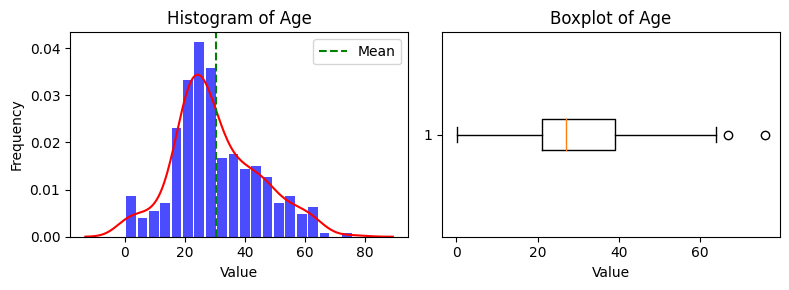

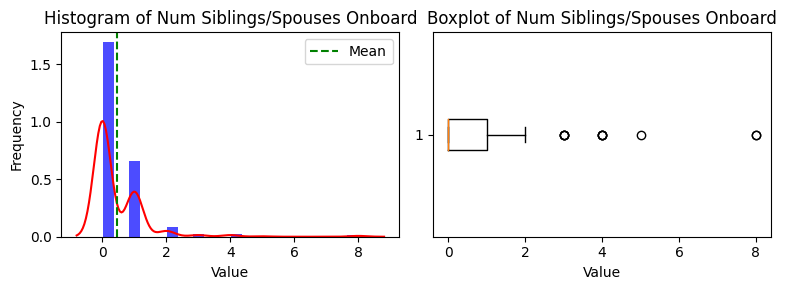

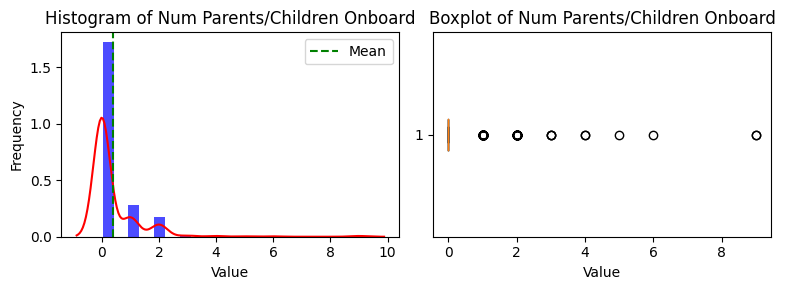

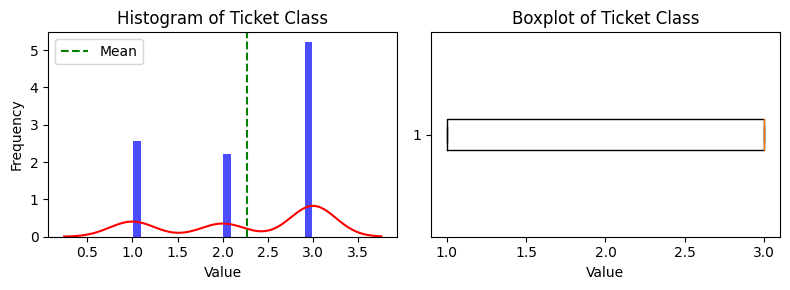

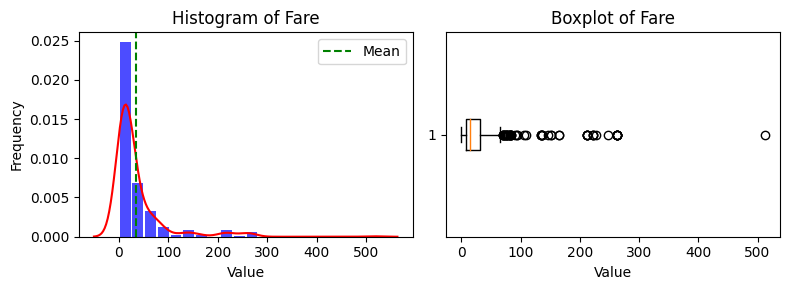

In [20]:
plot_histograms_and_boxplots(x_test_df)

3. Inspect the Categorical variables

In [14]:
def summarize_categorical_columns(df):
    cols_of_interest = df.select_dtypes(include=['O', 'bool', 'category']).columns
    results_list = []
    for col in cols_of_interest:
        non_none_count = df[col].count()
        none_count = df[col].isna().sum()
        empty_count = len(df[df[col] == ""])
        num_unique = len(df[col].unique())
        mode_value = df[col].mode().iloc[0]
        mode_count = df[col].value_counts()[mode_value]
        results_list.append([col, str(df[col].dtype), non_none_count, none_count, empty_count, num_unique, mode_value, mode_count])
    categorical_summary_df = pd.DataFrame(results_list, columns=["Column", "Column Type", "Non-None Count", "None Count", "Empty Count", "Num Unique", "Mode", "Mode Occurrences"])
    return categorical_summary_df

In [15]:
summarize_categorical_columns(x_test_df)

,Column,Column Type,Non-None Count,None Count,Empty Count,Num Unique,Mode,Mode Occurrences
0,Name,object,418,0,0,418,"Abbott, Master. Eugene Joseph",1
1,Sex,object,418,0,0,2,male,266
2,Ticket Num,object,418,0,0,363,PC 17608,5
3,Cabin Num,object,91,327,0,77,B57 B59 B63 B66,3
4,Embarkment Port,object,418,0,0,3,S,270


## Initial Ideas

* **PassengerId**: holds no predictive power and should not be included in the ML models
* **Name**: is unique across all records so will hold no predictive power. However, the surname and the title may be useful in identifying passengers who might be related. This should be extracted.
* **Sex**: of the passengers is unevenly distributed. This column can also be converted to binary
* **Age**
* **Num Siblings/Spouses Onboard**
* **Num Parents/Children Onboard**
* **Ticket Num**
* **Ticket Class**
* **Fare**
* **Cabin Num**
* **Embarkment Port**
* **Survived**: is unevenly distributed. 549 instances of zero, 442 instances of 1. This could lead to a bias towards the majority class.


## Further Data Preprocessing



In [16]:
# Use the data dictionary to replace some values
ticket_class_mapping = {1: '1st', 2: '2nd', 3: '3rd'}
df['Ticket Class'] = df['Ticket Class'].replace(ticket_class_mapping)
df['Ticket Class'] = pd.Categorical(df['Ticket Class'])

embarkment_mapping = {'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'}
df['Embarkment Port'] = df['Embarkment Port'].replace(embarkment_mapping)

NameError: name 'df' is not defined

## Further EDA

## Feature Engineering

In [ ]:
# # Resample the dataset

# # Separate features and target variable
# X = df_train.drop('Survived', axis=1)
# y = df_train['Survived']

# # Define the resampling pipeline
# resampling_pipeline = Pipeline([
#     ('oversample', SMOTE(sampling_strategy=0.5)),  # Oversample the minority class to have 50% of the majority class size
#     ('undersample', RandomUnderSampler(sampling_strategy=1.0))  # Undersample the majority class to have the same size as the minority class
# ])

# # Apply the resampling pipeline
# X_resampled, y_resampled = resampling_pipeline.fit_resample(X, y)

# # Convert the resampled data back to a DataFrame (optional)
# X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
# y_resampled_df = pd.DataFrame(y_resampled, columns=['Survived'])
# resampled_train_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# resampled_train_df

## Building a Transformation Pipeline